In [1]:
import urllib
import os
import numpy as np
from PIL import Image

In [2]:
def maybe_download(url, name):
    """ ファイルがなければダウンロード """
    if not os.path.exists(name):
        urllib.urlretrieve(url, name)
        print "File " + name + " downloaded!"
    return name

def read_tile(name):
    """ csv file -> numpy array """
    ret = np.genfromtxt(name, delimiter=",", filling_values=0.) # 'e' -> 0.0 （海など?）
    if ret.shape == (256, 256):
        return ret
    else: # 国外だとデータがないので0としておく
        return np.zeros((256, 256))

In [3]:
def get_maps(from_tile, to_tile=None, zoom=None, tile_type="std", ext="png",):
    """ 指定された領域に含まれるすべての地図タイルを任意のズームレベルで取得する
    Inputs:
        file_type, ext: 取得したいタイルの種類・拡張子
        -> http://cyberjapandata.gsi.go.jp/xyz/<tile_type>/{z}/{x}/{y}.<ext>を取得する
        from_tile, to_tile: 取得したい領域内の左上、右下のタイル座標（それぞれ[z, x, y]のリスト）
        zoom: ズームレベル
    Outputs:
        full_tile: 指定した領域の地図タイルを結合したもの（numpyのarray）
    """
    if zoom == None:# zoomを省略するとfrom_tileと同じになる
        zoom =from_tile[0]
    if to_tile == None:# to_tileを省略するとfrom_tileと同じになる
        to_tile = from_tile
    MAX_ZOOM = 18
    assert zoom <= MAX_ZOOM

    # 指定されたzoomにおける左上のタイル座標
    x1 = from_tile[1] * 2**(zoom - from_tile[0])
    y1 = from_tile[2] * 2**(zoom - from_tile[0])
    # 指定されたzoomにおける右下のタイル座標
    x2 = (to_tile[1] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    y2 = (to_tile[2] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    
    # 左上〜右下すべてのタイルの座標
    tile_list = []
    for j in range(y1, y2+1):
        tile_row = []
        for i in range(x1, x2+1):
            tile_row.append([zoom, i, j])
        tile_list.append(tile_row)
    
    # ダウンロード
    full_tile = []
    for tile_row in tile_list:
        tr = []
        for tile in tile_row:
            tile_url = "http://cyberjapandata.gsi.go.jp/xyz/{tile_type}/{z}/{x}/{y}.{ext}".format(tile_type=tile_type, 
                                                                                                  z=tile[0], x=tile[1], y=tile[2],
                                                                                                  ext=ext)
            if ext=="png" or ext=="jpg":
                tile_name = "{ext}/{tile_type}_{z}_{x}_{y}.{ext}".format(ext=ext, tile_type=tile_type, z=tile[0], x=tile[1], y=tile[2])
                maybe_download(tile_url, tile_name)
                tr.append(np.array(Image.open(tile_name)))
            elif ext=="txt":
                # save as .csv
                tile_name = "csv/{tile_type}_{z}_{x}_{y}.csv".format(tile_type=tile_type, z=tile[0], x=tile[1], y=tile[2])
                maybe_download(tile_url, tile_name)
                tr.append(read_tile(tile_name)) # 'e'->0.0
            else:
                raise ValueError(".jpg, .png, .txt supported")
        full_tile.append(np.hstack(tr))
    full_tile = np.vstack(full_tile)
    return full_tile

In [6]:
nabe_dem    = get_maps([15, 29047, 12929], [15, 29049, 12931], tile_type="dem5a", ext="txt")
nabe_std    = get_maps([15, 29047, 12929], [15, 29049, 12931])
nabe_relief = get_maps([15, 29047, 12929], [15, 29049, 12931], tile_type="relief")
mixed_map = (nabe_relief*0.5 + nabe_std*0.5).astype(np.uint8)

File png/std_15_29047_12929.png downloaded!
File png/std_15_29048_12929.png downloaded!
File png/std_15_29049_12929.png downloaded!
File png/std_15_29047_12930.png downloaded!
File png/std_15_29048_12930.png downloaded!
File png/std_15_29049_12930.png downloaded!
File png/std_15_29047_12931.png downloaded!
File png/std_15_29048_12931.png downloaded!
File png/std_15_29049_12931.png downloaded!
File png/relief_15_29047_12929.png downloaded!
File png/relief_15_29048_12929.png downloaded!
File png/relief_15_29049_12929.png downloaded!
File png/relief_15_29047_12930.png downloaded!
File png/relief_15_29048_12930.png downloaded!
File png/relief_15_29049_12930.png downloaded!
File png/relief_15_29047_12931.png downloaded!
File png/relief_15_29048_12931.png downloaded!
File png/relief_15_29049_12931.png downloaded!


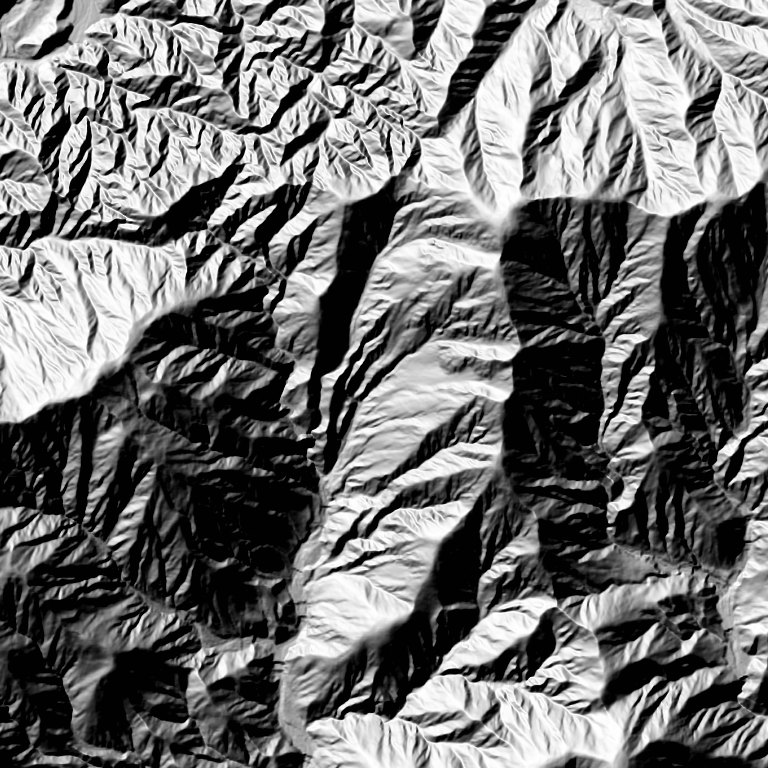

In [10]:
nabe_hill    = get_maps([15, 29047, 12929], [15, 29049, 12931], tile_type="hillshademap")
p0 = Image.fromarray(nabe_hill)
p0.save("static/hill.jpg")
p0

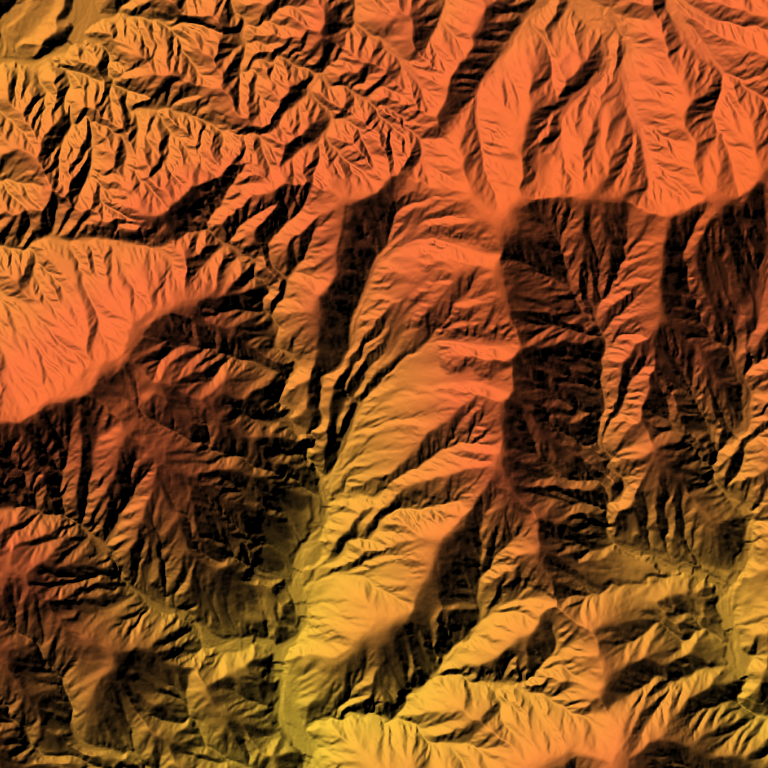

In [8]:
p1 = Image.fromarray(nabe_std)
p1.save("static/std.jpg")
p2 = Image.fromarray(nabe_relief)
p2.save("static/relief.jpg")
p2

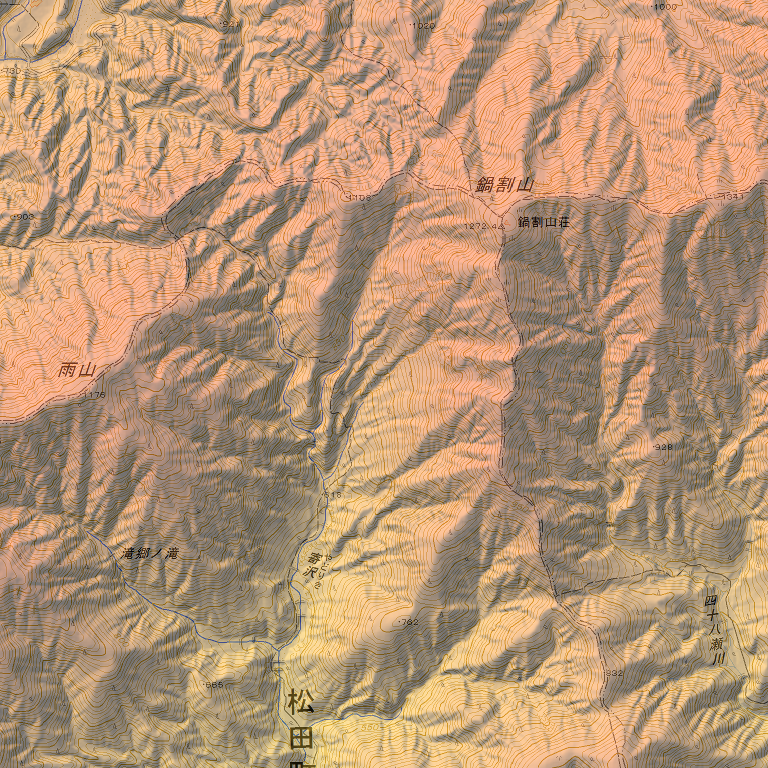

In [10]:
pilImg = Image.fromarray(mixed_map)
pilImg.save("fig/mixed.jpg")
pilImg